In [1]:

import DW_oscillator as DW
import numpy as np
from IPython.display import clear_output

from torchdiffeq import odeint
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import matplotlib.pyplot as plt

"run_field_sequence" that randomly generates and simulates a set of fields. It returns the time, DW position and angle plus the input time sequence.
field_low and field_high specify the range the fields will be generated over while N_fields is the number of fields in the sequence and T is the time period of each field.

The outputs of interest are t, y and h_t. y[0] is the DW position over time (at time points given in t) and h_t is the magnetic field (serves as input) at the same times.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
t, y, h_t, fields, periods = DW.run_field_sequence(field_low = 0, field_high = 500.0, N_fields = 10, T = 6,y0 = [0.0,0.0])

[253.39532837  20.1991129  311.00652871   6.54651878   2.71507284
 214.04519583 263.01181776  60.59147089  67.90516097 459.52798364]
[6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]


In [4]:
t.shape,y.shape,h_t.shape,fields.shape,periods.shape

((600,), (2, 600), (600,), (10,), (10,))

In [5]:
fields,periods

(array([253.39532837,  20.1991129 , 311.00652871,   6.54651878,
          2.71507284, 214.04519583, 263.01181776,  60.59147089,
         67.90516097, 459.52798364]),
 array([6., 6., 6., 6., 6., 6., 6., 6., 6., 6.]))

In [3]:
flag = False

In [ ]:
#h_t_ = torch.div(torch.tensor(h_t, dtype=torch.float64),1000.).to(device)  # Converting to column vector
y_0_ = torch.tensor(y[0], dtype=torch.float64)  # Converting to column vector
y_1_ = torch.tensor(y[1], dtype=torch.float64)  # Converting to column vector

# Stack the tensors horizontally
data = torch.stack((torch.div(y_0_, 1000.),y_1_)).to(device)  # Converting to column vector

In [8]:
train = data[:,:].transpose(0,1).to(device)

In [9]:
time_train = torch.tensor(t).to(device)

In [4]:
def get_batch(true_y,time, batch_size):
    num_samples = len(true_y)
    indices = np.random.choice(np.arange(num_samples - batch_size, dtype=np.int64), size=batch_size, replace=False)
    indices.sort()
    batch_y0 = true_y[indices]  # (batch_size, D)
    batch_t = time[:batch_size]  # (batch_size)
    batch_y = torch.stack([true_y[indices + i] for i in range(batch_size)], dim=0)  # (batch_size, M, D)
    indices = torch.tensor(indices)
    return batch_y0,batch_t,batch_y,indices

In [5]:
class sequence:
    """
    Callable class to produce a time-dependent field sequence using PyTorch tensors.
    """
    def __init__(self, fields, periods):
        self.fields = torch.tensor(fields, dtype=torch.float64).to(device)
        self.periods = torch.tensor(periods, dtype=torch.float64).to(device)
        self.periods_sum = torch.cumsum(self.periods, dim=0)

    def __call__(self, t):
        if t < 0.0:
            val = torch.tensor(0.0, dtype=torch.float64)
        elif t >= self.periods_sum[-1]:
            val = torch.tensor(0.0, dtype=torch.float64)
        else:
            t_diff = self.periods_sum - t
            n = 0
            for i in range(len(t_diff)):
                if t_diff[i] >= 0.0:
                    n = i 
                    break
            #n = torch.argmax(t_diff >= 0.0)  # Find the first index where t_diff >= 0.0
            val = self.fields[n]
        return val

In [12]:
h_time = sequence(fields,periods)

In [8]:
class DWODE(nn.Module):
    """
    neural network for learning the chaotic lorenz system
    """
    def __init__(self, h_time, frequency ):
        super(DWODE, self).__init__()
        self.lin = nn.Linear(3, 128)
        self.lin2 = nn.Linear(128, 256)
        self.lin3 = nn.Linear(256,512)
        self.lin4 = nn.Linear(512,1024)
        self.lin5 = nn.Linear(1024,2)
        self.tanh = nn.Tanh()
        self.lrelu = nn.LeakyReLU()
        self.h_time = h_time #  function to return the field magnitude at time t
        self.omega = 2*torch.pi * frequency # store the angular frequency for calculating field
        self.tanh = nn.Tanh()
        self.lrelu = nn.LeakyReLU()
        self.nfe = 0

    def forward(self,t,x):
        self.nfe += 1
        if flag == False:
            h_accumulator = torch.zeros_like(intervals, dtype=torch.float64)
            for i,j in enumerate(intervals):
            
                h = self.h_time(j) * torch.sin(self.omega*j )
                h_accumulator[i] = h
            h = torch.div(h_accumulator,1000.).unsqueeze(1)
        else : 
            h = self.h_time(t) * torch.sin(self.omega*t)
            h = torch.div(h,1000.).unsqueeze(0).unsqueeze(0)
        x_aug = torch.cat([x, h], 1)
        x = self.lrelu(self.lin(x_aug))
        x = self.lrelu(self.lin2(x))
        x = self.lrelu(self.lin3(x))
        x = self.tanh(self.lin4(x))
        x = self.lin5(x)
        return x
     

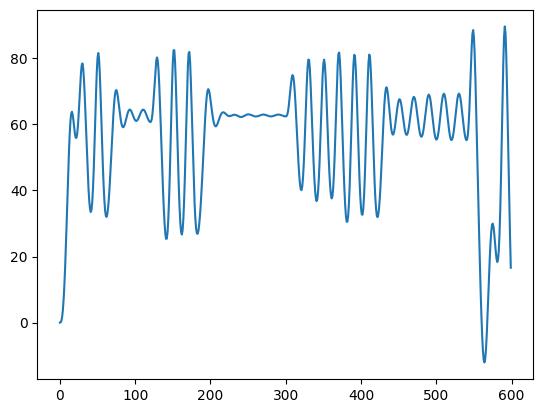

In [14]:
plt.plot(y[0])

In [15]:
model = DWODE(h_time,frequency=0.5).double().to(device)

In [16]:
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

In [17]:
# def app (indices):
#     omega = torch.tensor(2 * torch.pi * 0.5)  # f = 0.5
#     if flag == True:
#         h_accumulator = torch.zeros_like(torch.tensor([0.]), dtype=torch.float64)  # Initialize an empty tensor for h
#         omega = omega * time_train[0]
#         h = h_t_[0] * torch.sin(omega)
#         h_accumulator = h
#         return h_accumulator.unsqueeze(0)
#     h_accumulator = torch.zeros_like(indices, dtype=torch.float64)  # Initialize an empty tensor for h
    
#     for i in range(len(indices)):
#         omega = omega * time_train[indices[i]]  # Assuming t is defined elsewhere
#         h = h_t_[indices[i]] * torch.sin(omega)  # Assuming h_t is defined elsewhere
#         h_accumulator[i] = h  # Store the calculated h in the accumulator tensor
    
#     return h_accumulator.unsqueeze(0)  # Return the accumulator tensor
        

In [6]:
from torchdiffeq import odeint_adjoint as adjoint

Iter 0900 | Total Loss 0.000232


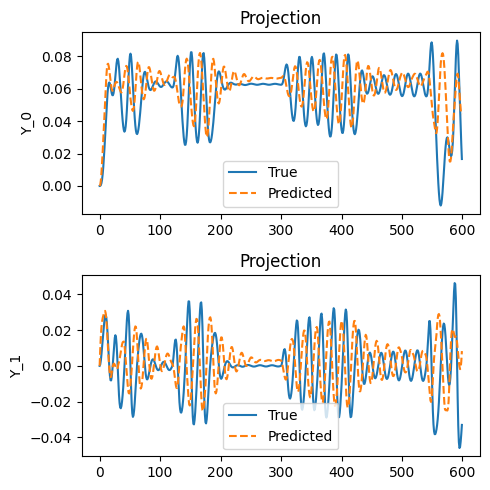

In [19]:
losses = []
whole_losses = []
best_loss = 100.0
batch_size = 16
for i in range(1000):

    optimizer.zero_grad()
    
    init,batch_t,truth,indices = get_batch(train,time_train,batch_size)
    intervals = time_train[indices]
    #print(init,batch_t,truth)
    pred_y = adjoint(model,init,batch_t,method='dopri5')
    loss = F.huber_loss(pred_y, truth)
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    if loss.item() < best_loss:
                best_loss = loss.item()
                torch.save(model.state_dict(), 'saved_models/multiple_forward_field_3.pth')
    if i % 100 == 0:
        
        with torch.no_grad():
            flag = True
            intervals = time_train
            pred_y = adjoint(model, train[0].view(1,-1), time_train,method='dopri5')
            pred_y = pred_y.squeeze(1)
            loss = F.huber_loss(pred_y, train)
            whole_losses.append(loss.item())
            flag = False
            print('Iter {:04d} | Total Loss {:.6f}'.format(i, loss.item()))
            x_pred = pred_y[:,0].cpu()
            y_pred = pred_y[:,1].cpu()
            

            # Extract the x, y, z coordinates from X_train_plt
            x_train = train[:,0].cpu()
            y_train = train[:,1].cpu()
            

            fig, ax = plt.subplots(2, 1, figsize=(5, 5))
            ax[0].plot(x_train, label='True')
            ax[0].plot(x_pred, label='Predicted', linestyle='--')
            ax[0].set_ylabel('Y_0')
            ax[0].set_title('Projection')
            ax[0].legend()

            ax[1].plot(y_train, label='True')
            ax[1].plot(y_pred, label='Predicted',linestyle='--')
            ax[1].set_ylabel('Y_1')
            ax[1].set_title('Projection')
            ax[1].legend()


            plt.tight_layout()
            plt.show()
            clear_output(wait=True)

In [20]:
print(best_loss)

7.97419673889996e-06


In [9]:
test_model = DWODE(h_time,0.5).double().to(device)

NameError: name 'h_time' is not defined

In [22]:
test_model.load_state_dict(torch.load('saved_models/multiple_forward_field_3.pth'))

<All keys matched successfully>

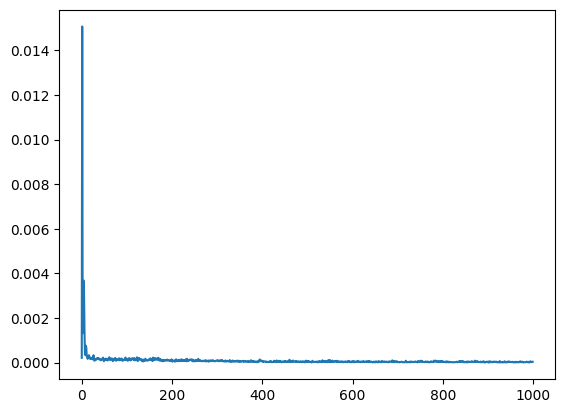

In [23]:
plt.plot(losses)
plt.show()

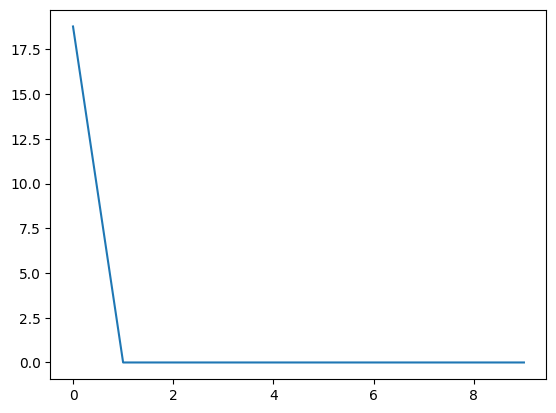

In [24]:
plt.plot(whole_losses)

plt.show()

In [25]:
with torch.no_grad():
    flag = True
    intervals = time_train
    pred = adjoint(test_model, train[0].view(1,-1), time_train,method='dopri5')
    loss = F.huber_loss(pred, train)
    flag = False

In [26]:
pred = pred.cpu().detach().numpy()

In [27]:
pred = pred.squeeze(1)

In [28]:
pred.shape,train.shape

((600, 2), torch.Size([600, 2]))

In [29]:
data = data.transpose(0,1)

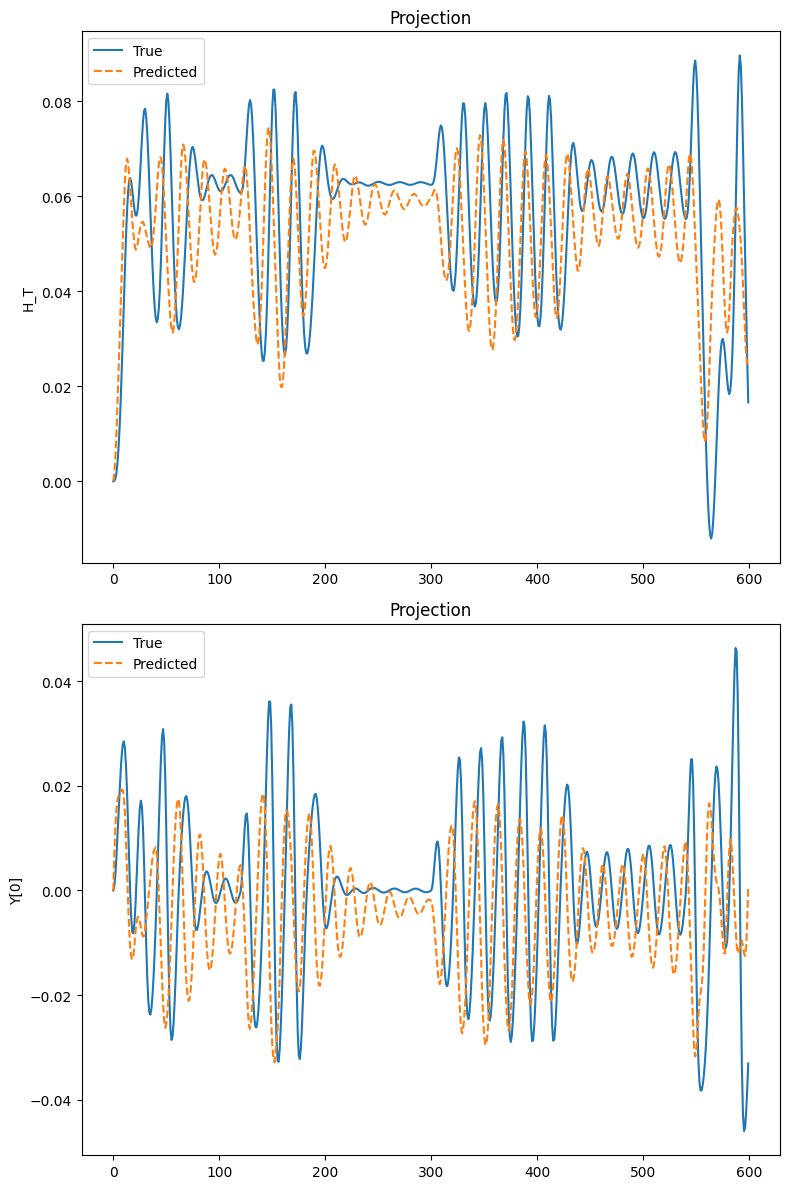

In [30]:
# Extract the x, y, z coordinates from predictions_plt
x_pred = pred[:,0]
y_pred = pred[:,1]


# Extract the x, y, z coordinates from X_train_plt
x_train = train[:,0].cpu()
y_train = train[:,1].cpu()

fig, ax = plt.subplots(2, 1, figsize=(8, 12))
ax[0].plot(x_train, label='True')
ax[0].plot(x_pred, label='Predicted',linestyle='--')
ax[0].set_ylabel('H_T')
ax[0].set_title('Projection')
ax[0].legend()

ax[1].plot(y_train, label='True')
ax[1].plot(y_pred, label='Predicted',linestyle='--')
ax[1].set_ylabel('Y[0]')
ax[1].set_title('Projection')

ax[1].legend()
plt.savefig('multiple_forward_field_3.png')
plt.tight_layout()
plt.show()

In [10]:
t_, y_, ht, fields_, periods_ = DW.run_field_sequence(field_low = 0, field_high = 500.0, N_fields = 10, T = 10,y0 = [0.0,0.0])

[329.96166693 342.84893081 241.58321796  27.10567685 132.94038863
  79.2643228  126.6714536  182.32972763 409.97049514 382.05819553]
[10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]


In [92]:
h_t_ = torch.div(torch.tensor(ht, dtype=torch.float64),1000.).to(device)  # Converting to column vector
y_0_ = torch.tensor(y_[0], dtype=torch.float64)  # Converting to column vector
y_1_ = torch.tensor(y_[1], dtype=torch.float64)  # Converting to column vector

# Stack the tensors horizontally
data_ = torch.stack((torch.div(y_0_, 1000.),y_1_)).to(device)  # Converting to column vector

In [93]:
test_train = torch.tensor(t_).to(device)

In [94]:
test = data_[:,:].transpose(0,1).to(device)

In [95]:
h_time = sequence(fields_,periods_)

In [96]:
test_model = DWODE(h_time,frequency=0.5).double().to(device)

In [97]:
test_model.load_state_dict(torch.load('saved_models/multiple_forward_field_3.pth'))

<All keys matched successfully>

In [113]:
with torch.no_grad():
    flag = True
    intervals = test_train
    pred = adjoint(test_model, test[0].view(1,-1), test_train,method='dopri5')
    loss = F.huber_loss(pred.squeeze(1), test)
    flag = False

In [114]:
loss

tensor(0.0001, device='cuda:0', dtype=torch.float64)

In [108]:
pred.shape,test.shape

(torch.Size([1000, 1, 2]), torch.Size([1000, 2]))

In [88]:
def plot_vector_field(pred,label):
    for idx in range(len(pred)):
        positions = pred[idx][:,:2]  # Extracting the 3 components as positions

        # Create a new tensor with requires_grad=True
        positions = positions.clone().detach().requires_grad_(True)

        # Calculate the vector field by taking the derivatives of positions
        vector_field = torch.autograd.grad(positions, positions, torch.ones_like(positions), create_graph=True)[0]

        # Extract the x, y, and z components of the vector field
        U = vector_field[:, 0]
        V = vector_field[:, 1]
        

        # Move tensors to CPU before converting to NumPy arrays
        positions = positions.cpu().detach().numpy()
        U = U.cpu().detach().numpy()
        V = V.cpu().detach().numpy()
        

        # Create a subset of positions for the arrows
        arrow_step = 1  # Adjust this to change the density of arrows
        arrow_positions = positions[::arrow_step]

        # Calculate arrow directions by normalizing the vector field components
        magnitude = np.sqrt(U**2 + V**2)
        arrow_U = U / magnitude
        arrow_V = V / magnitude

        # Plot the vector field with arrows
        fig, ax = plt.subplots(figsize=(4, 4))
        ax.quiver(arrow_positions[:, 0], arrow_positions[:, 1], arrow_U[::arrow_step], arrow_V[::arrow_step], width=0.004, alpha=0.6)
        plt.title(f'Domain Wall Multiple field  Vector Field of {label}_{idx}  Predictions')
        plt.savefig(f'PNG/pdomain_NODE_Vector_Field_{label}_{idx}.png', format='png', dpi=400, bbox_inches ='tight', pad_inches = 0.1)
        plt.tight_layout()
        plt.show()

In [109]:
pred = pred.cpu().detach().numpy()

In [115]:
pred = torch.tensor(pred).squeeze(1).unsqueeze(0)

C:\Users\jagpr\AppData\Local\Temp\ipykernel_58624\1892867842.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(pred).squeeze(1).unsqueeze(0)


In [117]:
pred.shape

torch.Size([1, 1000, 2])

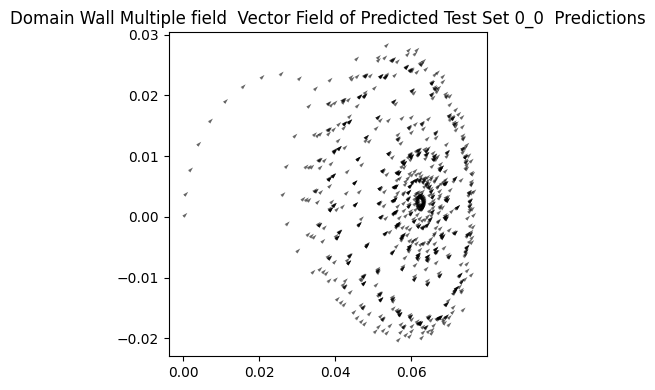

In [116]:
plot_vector_field(pred,'Predicted Test Set 0')

Text(0.5, 1.0, 'True Test Set 0')

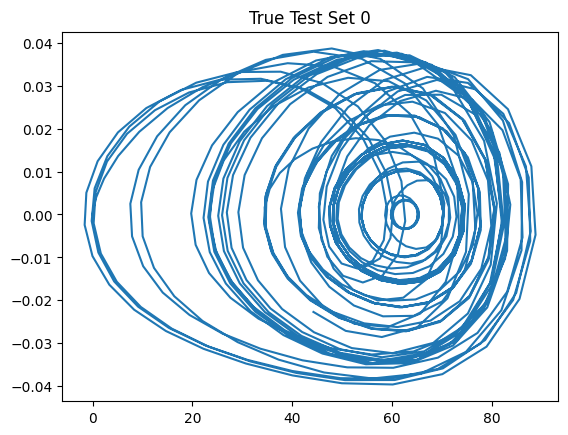

In [45]:
plt.plot(y_[0],y_[1])
plt.title('True Test Set 0')

In [41]:
data_ = data_.transpose(0,1)

In [37]:
pred = pred.squeeze(1)

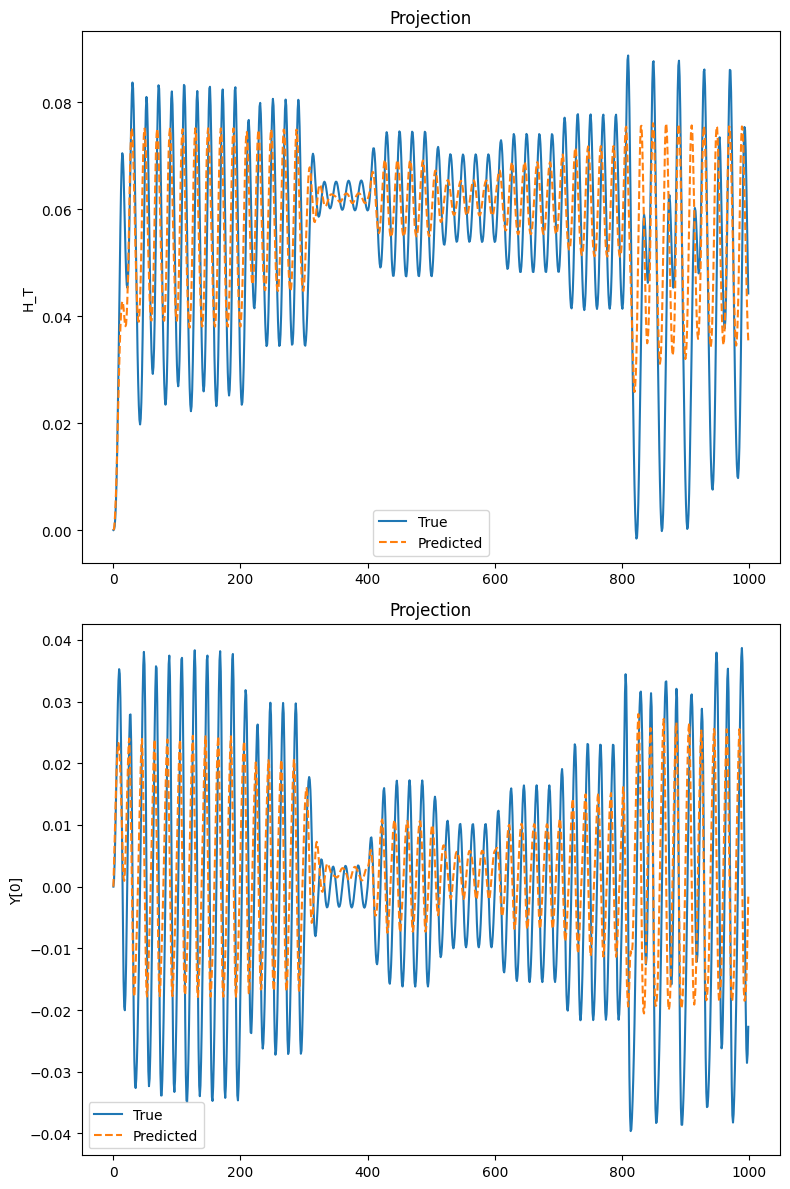

In [38]:
# Extract the x, y, z coordinates from predictions_plt
x_pred = pred[:,0]
y_pred = pred[:,1]


# Extract the x, y, z coordinates from X_train_plt
x_train = test[:,0].cpu()
y_train = test[:,1].cpu()

fig, ax = plt.subplots(2, 1, figsize=(8, 12))
ax[0].plot(x_train, label='True')
ax[0].plot(x_pred, label='Predicted',linestyle='--')
ax[0].set_ylabel('H_T')
ax[0].set_title('Projection')
ax[0].legend()

ax[1].plot(y_train, label='True')
ax[1].plot(y_pred, label='Predicted',linestyle='--')
ax[1].set_ylabel('Y[0]')
ax[1].set_title('Projection')

ax[1].legend()
plt.savefig('multiple_forward_field_test_data.png')
plt.tight_layout()
plt.show()

In [46]:
t_1, y_1, ht_1, fields_1, periods_1 = DW.run_field_sequence(field_low = 0, field_high = 500.0, N_fields = 10, T = 10,y0 = [0.0,0.0])

[144.94786709 298.91929209 486.3229457   57.64407563 173.45140805
 190.65888406 492.39231278 361.11110949 171.57925701  48.30100152]
[10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]


In [118]:
h_time = sequence(fields_1,periods_1)

In [119]:
test_time_1 = torch.tensor(t_1).to(device)

In [120]:
h_t_ = torch.div(torch.tensor(ht_1, dtype=torch.float64),1000.).to(device)  # Converting to column vector
y_0_ = torch.tensor(y_1[0], dtype=torch.float64)  # Converting to column vector
y_1_ = torch.tensor(y_1[1], dtype=torch.float64)  # Converting to column vector

# Stack the tensors horizontally
data_ = torch.stack((torch.div(y_0_, 1000.),y_1_)).to(device)  # Converting to column vector

In [121]:
test = data_[:,:].transpose(0,1).to(device)

In [122]:
with torch.no_grad():
    flag = True
    intervals = test_train
    pred = adjoint(test_model, test[0].view(1,-1), test_time_1,method='dopri5')
    loss = F.huber_loss(pred.squeeze(1), test)
    flag = False

In [123]:
loss

tensor(0.0008, device='cuda:0', dtype=torch.float64)

Text(0.5, 1.0, 'True Test Set 1')

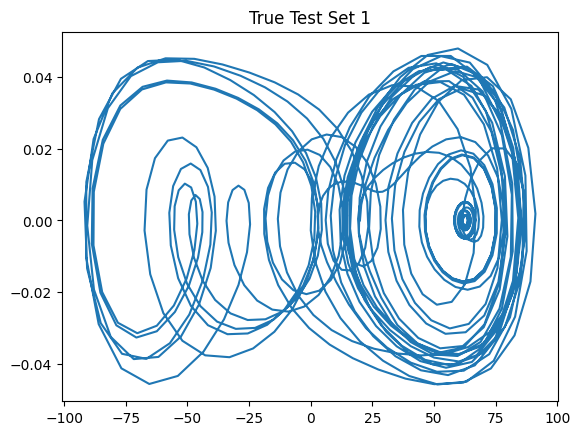

In [124]:
plt.plot(y_1[0],y_1[1])
plt.title('True Test Set 1')

In [125]:
pred.shape

torch.Size([1000, 1, 2])

In [126]:
to_vector = pred.squeeze(1).unsqueeze(0)

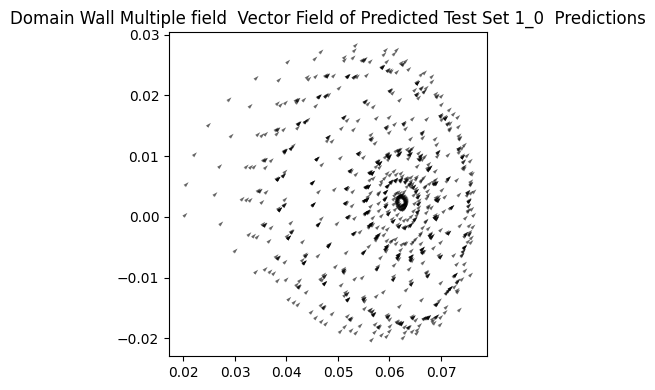

In [127]:
plot_vector_field(to_vector,'Predicted Test Set 1')

In [68]:
pred = pred.cpu().detach().squeeze(1)

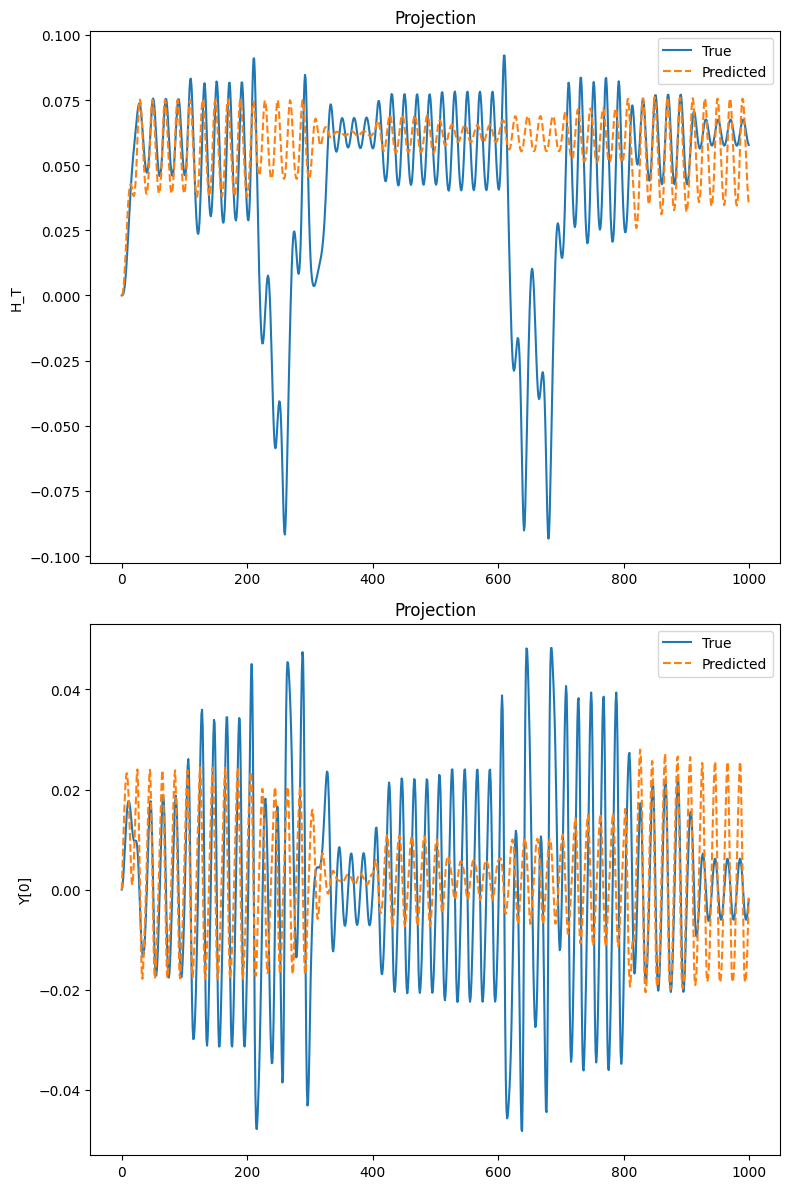

In [69]:
# Extract the x, y, z coordinates from predictions_plt
x_pred = pred[:,0]
y_pred = pred[:,1]


# Extract the x, y, z coordinates from X_train_plt
x_train = test[:,0].cpu()
y_train = test[:,1].cpu()

fig, ax = plt.subplots(2, 1, figsize=(8, 12))
ax[0].plot(x_train, label='True')
ax[0].plot(x_pred, label='Predicted',linestyle='--')
ax[0].set_ylabel('H_T')
ax[0].set_title('Projection')
ax[0].legend()

ax[1].plot(y_train, label='True')
ax[1].plot(y_pred, label='Predicted',linestyle='--')
ax[1].set_ylabel('Y[0]')
ax[1].set_title('Projection')

ax[1].legend()
plt.savefig('multiple_forward_field_test_data_1.png')
plt.tight_layout()
plt.show()

In [70]:
t_1, y_1, ht_1, fields_1, periods_1 = DW.run_field_sequence(field_low = 0, field_high = 500.0, N_fields = 10, T = 10,y0 = [20.0,0.0])

[368.39828591 437.63284412 140.76849796  10.75675635 478.17111307
 465.64212293 413.51737694 481.89220302  22.12625991  40.6631365 ]
[10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]


In [136]:
h_t_ = torch.div(torch.tensor(ht_1, dtype=torch.float64),1000.).to(device)  # Converting to column vector
y_0_ = torch.tensor(y_1[0], dtype=torch.float64)  # Converting to column vector
y_1_ = torch.tensor(y_1[1], dtype=torch.float64)  # Converting to column vector

# Stack the tensors horizontally
data_ = torch.stack((torch.div(y_0_, 1000.),y_1_)).to(device)  # Converting to column vector

In [137]:
test = data_[:,:].transpose(0,1).to(device)

In [138]:
with torch.no_grad():
    flag = True
    intervals = test_train
    pred = adjoint(test_model, test[0].view(1,-1), test_time_1,method='dopri5')
    loss = F.mse_loss(pred.squeeze(1), test)
    flag = False

In [139]:
loss

tensor(0.0016, device='cuda:0', dtype=torch.float64)

Text(0.5, 1.0, 'True Test Set 2')

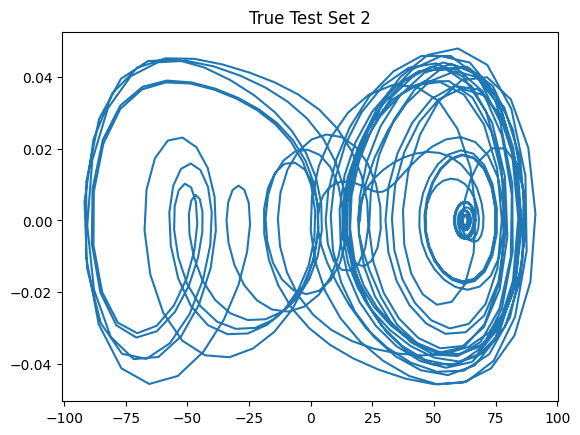

In [142]:
plt.plot(y_1[0],y_1[1])
plt.title('True Test Set 2')

In [140]:
to_vector = pred.squeeze(1).unsqueeze(0)

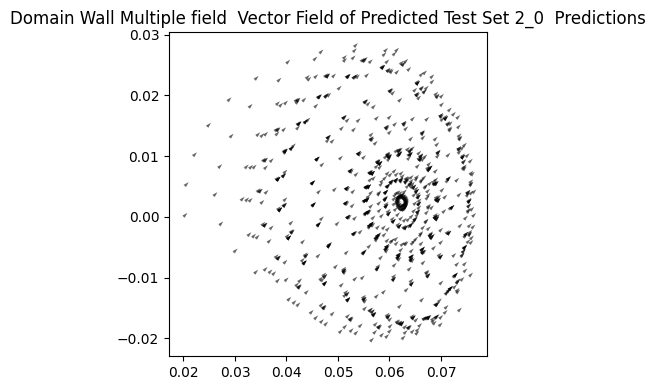

In [141]:
plot_vector_field(to_vector,'Predicted Test Set 2')

In [135]:
pred = pred.cpu().detach().squeeze(1)

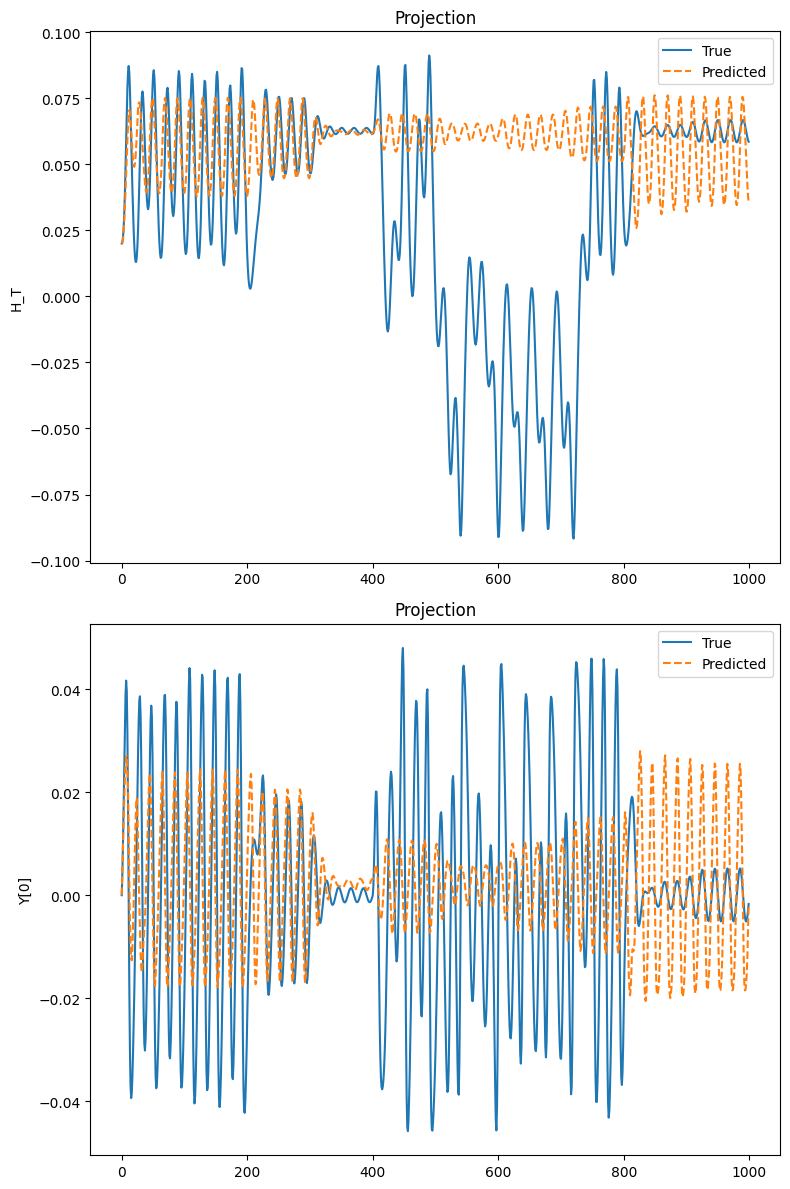

In [79]:
# Extract the x, y, z coordinates from predictions_plt
x_pred = pred[:,0]
y_pred = pred[:,1]


# Extract the x, y, z coordinates from X_train_plt
x_train = test[:,0].cpu()
y_train = test[:,1].cpu()

fig, ax = plt.subplots(2, 1, figsize=(8, 12))
ax[0].plot(x_train, label='True')
ax[0].plot(x_pred, label='Predicted',linestyle='--')
ax[0].set_ylabel('H_T')
ax[0].set_title('Projection')
ax[0].legend()

ax[1].plot(y_train, label='True')
ax[1].plot(y_pred, label='Predicted',linestyle='--')
ax[1].set_ylabel('Y[0]')
ax[1].set_title('Projection')

ax[1].legend()
plt.savefig('multiple_forward_field_test_data_2.png')
plt.tight_layout()
plt.show()